In [1]:
#!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 99.7/99.7 MB 1.2 MB/s eta 0:00:00


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

## 1. Load Dataset

In [2]:
# data training; ada 3 data training yg berbeda yaitu under, over sampling, dan smote
x_rus = joblib.load("data/processed/x_rus.pkl")
y_rus = joblib.load("data/processed/y_rus.pkl")

x_ros = joblib.load("data/processed/x_ros.pkl")
y_ros = joblib.load("data/processed/y_ros.pkl")

x_sm = joblib.load("data/processed/x_sm.pkl")
y_sm = joblib.load("data/processed/y_sm.pkl")

# data validation
x_valid = joblib.load("data/processed/x_valid_feng.pkl")
y_valid = joblib.load("data/processed/y_valid_feng.pkl")

# data test
x_test = joblib.load("data/processed/x_test_feng.pkl")
y_test = joblib.load("data/processed/y_test_feng.pkl")

## 2. Create Log Template

In [3]:
# function cek training, prediction. dan sebagainya dilakukan jam berap
def time_stamp():
    return datetime.now()

In [4]:
def create_log_template():
    logger = {
        "model_name" : [], 
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [5]:
# membuat/mengupdate training log
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe: # kalo ga ada maka di create baru
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## 2. Training and Evaluation

### 2.1. Create Model Object

In [35]:
#!pip3 install jupyter-tabnine
#!jupyter nbextension install --py jupyter_tabnine
#!jupyter nbextension enable --py jupyter_tabnine
#!jupyter serverextension enable --py jupyter_tabnine

Installing C:\Users\ASUS\anaconda3\lib\site-packages\jupyter_tabnine\static -> jupyter_tabnine
Making directory: C:\ProgramData\jupyter\nbextensions\jupyter_tabnine\
Copying: C:\Users\ASUS\anaconda3\lib\site-packages\jupyter_tabnine\static\main.css -> C:\ProgramData\jupyter\nbextensions\jupyter_tabnine\main.css
Copying: C:\Users\ASUS\anaconda3\lib\site-packages\jupyter_tabnine\static\main.js -> C:\ProgramData\jupyter\nbextensions\jupyter_tabnine\main.js
Copying: C:\Users\ASUS\anaconda3\lib\site-packages\jupyter_tabnine\static\README.md -> C:\ProgramData\jupyter\nbextensions\jupyter_tabnine\README.md
Copying: C:\Users\ASUS\anaconda3\lib\site-packages\jupyter_tabnine\static\tabnine.yaml -> C:\ProgramData\jupyter\nbextensions\jupyter_tabnine\tabnine.yaml
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable jupyter_tabnine --py
    
Enabling notebook extension jupyter_tabnine/main...
    

In [6]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [7]:
# list model nya berdasarkan data training
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

### 2.2. Training Model

In [8]:
# function untuk training dan validasi model
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"] 

        start_time = time_stamp() # membuat time stamp
        model["model_object"].fit(x_train, y_train) # model di fit ke data train, yaitu si 5 model tadi
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds() # menghitung durasi trainig

        y_pred = model["model_object"].predict(x_valid) # melakukan prediksi ke data validation
        performance = classification_report(y_valid, y_pred, output_dict = True)

        # generate model uid
        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        # ngisi value berdasarkan key- nya dari masing2 model ke log yg udh dibuat td
        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path) # update log di logger terbaru

    return training_log, list_of_model

#### 2.2.1. Baseline Model Undersampling

In [9]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"], 
    "baseline_model", 
    x_rus, 
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.61it/s]


In [12]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

#### 2.2.2. Baseline Model Oversampling

In [11]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_ros,
    y_ros,
    "oversampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


In [12]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

#### 2.2.3. Baseline Model SMOTE

In [13]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_sm,
    y_sm,
    "smote",
    x_valid,
    y_valid,
    "log/training_log.json"
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


In [14]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

#### 2.3.4. Best Performance

In [15]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame() # ubah log td jd dataframe

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    # di sort berdasarkan average f1 score tertinggi dan training time tercepat
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [16]:
training_res = training_log_to_df(training_log)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 284.48it/s]


In [17]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-XGBClassifier,6fdfbe53e32a1c2381bfd8b97f2b6451,0.088784,2023-10-05 00:34:59.196587,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-XGBClassifier,ff9a0a782004dee599b0050ee08494f3,0.097511,2023-10-05 00:35:39.751037,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-DecisionTreeClassifier,13350516798b5522bba40ced96fb22ff,0.007423,2023-10-05 00:34:58.815942,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,oversampling
3,baseline_model-DecisionTreeClassifier,b6a638bf4eba81927b800134ecc03eb3,0.012071,2023-10-05 00:35:39.233439,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,smote
4,baseline_model-RandomForestClassifier,6d1d90f3117dc61ac7ed20db0107f1c8,0.298535,2023-10-05 00:34:58.835126,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,oversampling
5,baseline_model-RandomForestClassifier,33b2a998b6b1cb777eabe6799df2f087,0.428601,2023-10-05 00:35:39.257139,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,smote
6,baseline_model-DecisionTreeClassifier,6070229d9f8dc2439af0367644821813,0.002003,2023-10-04 18:36:45.700232,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,oversampling
7,baseline_model-DecisionTreeClassifier,e07c0706cdf0b5e3bd27f2bc461e5b7d,0.002839,2023-10-04 18:35:57.274370,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,undersampling
8,baseline_model-DecisionTreeClassifier,fe786c6833ac8879efa5ef896c048214,0.003573,2023-10-04 18:37:22.025050,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,smote
9,baseline_model-DecisionTreeClassifier,2e1807c20b250fde68e0224691fc7309,0.004574,2023-10-05 00:33:53.668427,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,undersampling


In [18]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object    

In [19]:
model = get_best_model(training_res, list_of_model)

In [20]:
model 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
joblib.dump(model, "models/model.pkl") # model disimpan di pikel file

['models/model.pkl']

#### 2.2.5. Hyperparameter Tuning

In [21]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [22]:
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [23]:
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [24]:
training_log, list_of_model_rus_hyp = train_eval_model(
    [list_of_model["undersampling"][-1]],
    "hyperparams",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "log/training_log.json"
)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


In [25]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [26]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': 'b26579cbafb994a82108061756565a6e'}

In [27]:
training_log_to_df(training_log)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 277.28it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-XGBClassifier,6fdfbe53e32a1c2381bfd8b97f2b6451,0.088784,2023-10-05 00:34:59.196587,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
1,baseline_model-XGBClassifier,ff9a0a782004dee599b0050ee08494f3,0.097511,2023-10-05 00:35:39.751037,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
2,baseline_model-DecisionTreeClassifier,13350516798b5522bba40ced96fb22ff,0.007423,2023-10-05 00:34:58.815942,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,oversampling
3,baseline_model-DecisionTreeClassifier,b6a638bf4eba81927b800134ecc03eb3,0.012071,2023-10-05 00:35:39.233439,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,smote
4,baseline_model-RandomForestClassifier,6d1d90f3117dc61ac7ed20db0107f1c8,0.298535,2023-10-05 00:34:58.835126,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,oversampling
5,baseline_model-RandomForestClassifier,33b2a998b6b1cb777eabe6799df2f087,0.428601,2023-10-05 00:35:39.257139,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990197,smote
6,baseline_model-DecisionTreeClassifier,6070229d9f8dc2439af0367644821813,0.002003,2023-10-04 18:36:45.700232,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,oversampling
7,baseline_model-DecisionTreeClassifier,e07c0706cdf0b5e3bd27f2bc461e5b7d,0.002839,2023-10-04 18:35:57.274370,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,undersampling
8,baseline_model-DecisionTreeClassifier,fe786c6833ac8879efa5ef896c048214,0.003573,2023-10-04 18:37:22.025050,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,smote
9,baseline_model-DecisionTreeClassifier,2e1807c20b250fde68e0224691fc7309,0.004574,2023-10-05 00:33:53.668427,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980693,undersampling


#### 2.2.6. Take a Look at Confusion Matrix

In [28]:
y_pred = model.predict(x_valid)

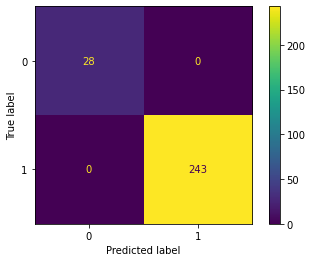

In [29]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

In [30]:
# terlihat hasil prediksi nya benar semua, kemungkinan overfit
# bisa jd karna data sedikit tp model kompleks, model terlalu menghafal data training